<a href="https://colab.research.google.com/github/pankaj18/time_series_forecasting/blob/master/forecasting_on_synthetic_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
import tensorflow as tf
from tensorflow import keras

In [0]:
plt.style.use('dark_background')

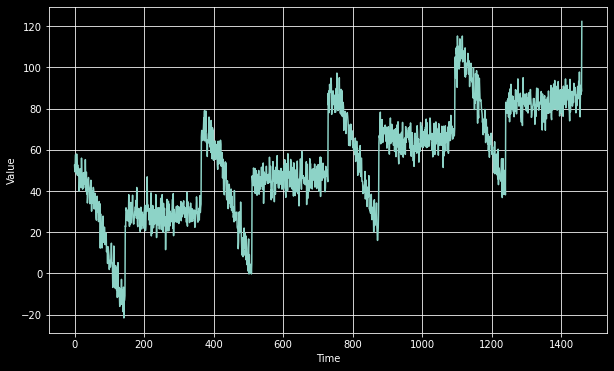

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

split time series in train and val

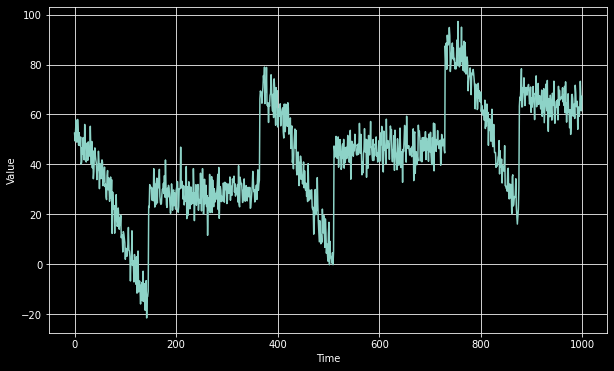

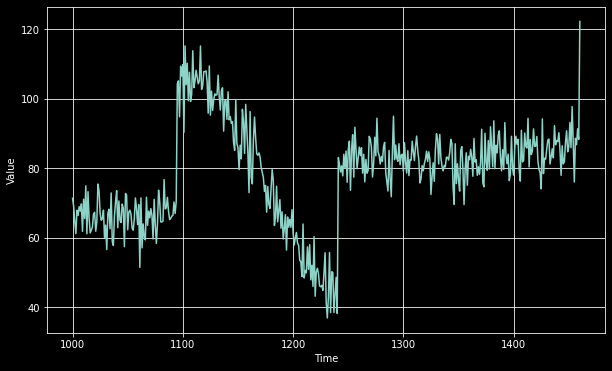

In [5]:
split_time=1000
time_train=time[:split_time]
x_train=series[:split_time]
time_valid=time[split_time:]
x_val=series[split_time:]
plt.figure(figsize=(10,6))
plot_series(time_train,x_train)
plt.show()
plt.figure(figsize=(10,6))
plot_series(time_valid,x_val)
plt.show()

# Naive Forecast

In [0]:
naive_forecast=series[split_time-1:-1]

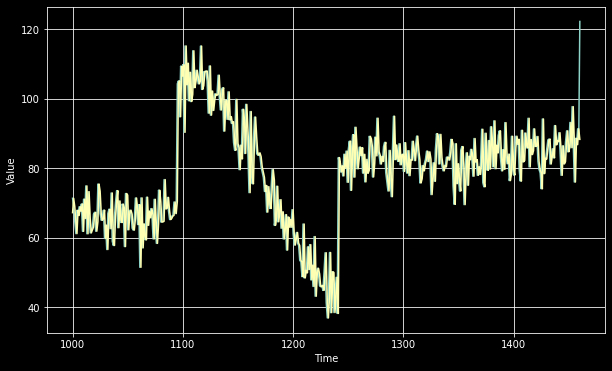

In [8]:
plt.figure(figsize=(10,6))
plot_series(time_valid,x_val)
plot_series(time_valid,naive_forecast)
plt.show()

zoom in for better view

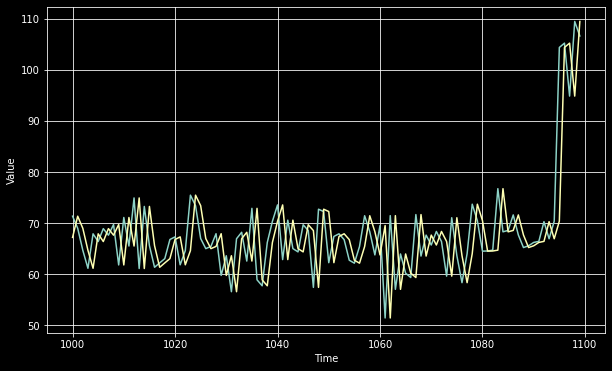

In [10]:
start=0
end=100
plt.figure(figsize=(10,6))
plot_series(time_valid[start:end],x_val[start:end])
plot_series(time_valid[start:end],naive_forecast[start:end])
plt.show()

# mean squared error and mean absolute error

In [12]:
print("mse:"+str(keras.metrics.mean_squared_error(x_val,naive_forecast).numpy()))
print("mae:"+str(keras.metrics.mean_absolute_error(x_val,naive_forecast).numpy()))

mse:61.827538
mae:5.937908


# Forecast using moving average

In [0]:
def moving_avg_forecast(series,window):
  forecast = []
  for time in range(len(series) - window):
    forecast.append(series[time:time + window].mean())
  return np.array(forecast)

In [0]:
ma_forecast=moving_avg_forecast(series,window=20)

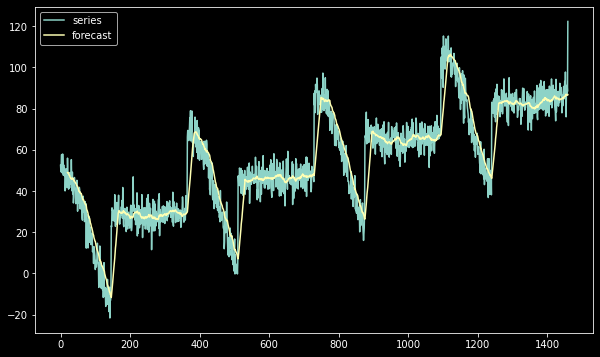

In [55]:
plt.figure(figsize=(10,6))
plt.plot(time,series,label='series')
plt.plot(time[20:],ma_forecast,label='forecast')
plt.legend()
plt.show()

In [0]:
ma_forecast_val=ma_forecast[split_time-20:]

In [57]:
print("mse:"+str(keras.metrics.mean_squared_error(x_val,ma_forecast_val).numpy()))
print("mae:"+str(keras.metrics.mean_absolute_error(x_val,ma_forecast_val).numpy()))

mse:78.59133
mae:6.030978


window_size=30

In [58]:
ma_forecast=moving_avg_forecast(series,window=10)
ma_forecast_val=ma_forecast[split_time-10:]
print("mse:"+str(keras.metrics.mean_squared_error(x_val,ma_forecast_val).numpy()))
print("mae:"+str(keras.metrics.mean_absolute_error(x_val,ma_forecast_val).numpy()))

mse:54.032284
mae:5.109333


# Removing seasonality

 the seasonality period is 365 days, we will subtract the value at time t – 365 from the value at time t

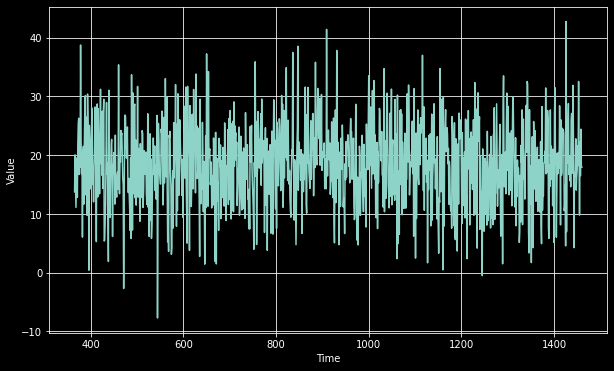

1096


In [62]:
diff_series = (series[365:] - series[:-365])
diff_time = time[365:]

plt.figure(figsize=(10, 6))
plot_series(diff_time, diff_series)
plt.show()
print(len(diff_series))

In [67]:
print(len(series))

1461


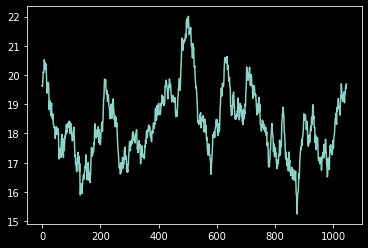

1046


In [68]:
diff_moving_avg = moving_avg_forecast(diff_series, 50)
plt.plot(diff_moving_avg)
plt.show()
print(len(diff_moving_avg))

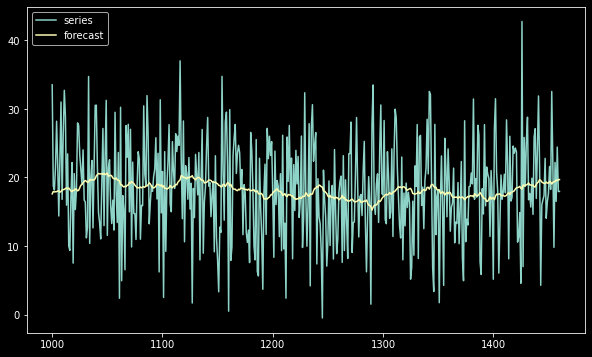

In [69]:
diff_moving_avg = moving_avg_forecast(diff_series, 50)[split_time - 365-50:]
plt.figure(figsize=(10, 6))
plt.plot(time_valid, diff_series[split_time - 365:],label='series')
plt.plot(time_valid, diff_moving_avg,label='forecast')
plt.legend()
plt.show()

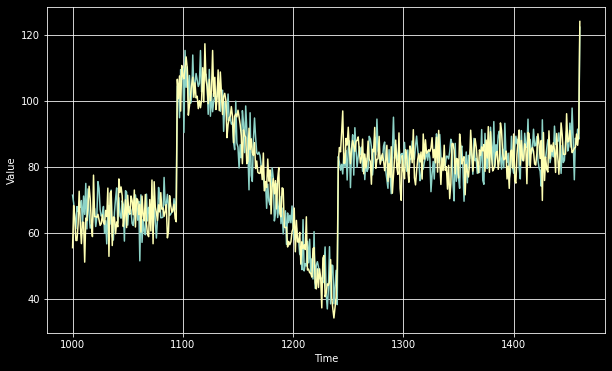

In [70]:
diff_moving_avg_plus_past = series[split_time - 365:-365] + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_val)
plot_series(time_valid, diff_moving_avg_plus_past)
plt.show()

In [71]:
print(keras.metrics.mean_squared_error(x_val, diff_moving_avg_plus_past).numpy())
print(keras.metrics.mean_absolute_error(x_val, diff_moving_avg_plus_past).numpy())

52.97366
5.839311


Better than naive forecast, good. However the forecasts look a bit too random, because we're just adding past values, which were noisy. Let's use a moving averaging on past values to remove some of the noise:

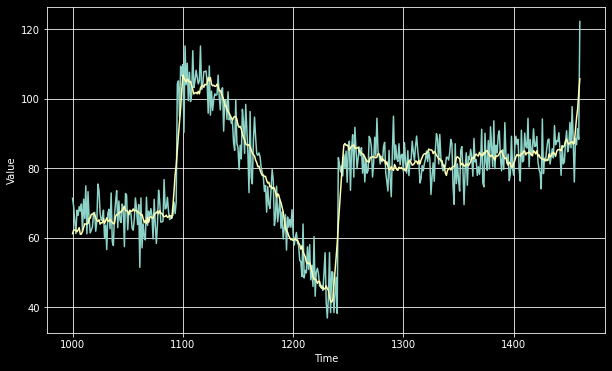

In [72]:
diff_moving_avg_plus_smooth_past = moving_avg_forecast(series[split_time - 370:-360], 10) + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_val)
plot_series(time_valid, diff_moving_avg_plus_smooth_past)
plt.show()

In [74]:
print(keras.metrics.mean_squared_error(x_val, diff_moving_avg_plus_smooth_past).numpy())
print(keras.metrics.mean_absolute_error(x_val, diff_moving_avg_plus_smooth_past).numpy())

33.45226
4.569442


In [0]:
print(keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())
print(keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())